# Stochastic Variational Inference Part 2 - Examples & Comparison with MCMC

In part one of this article, I introduced the theoretical basis for SVI along with a one dimensional toy example to introduce the basic ideas behind its function. I also presented a few stripped-down examples of NumPyro's SVI features, including some simple cases of its automatic guide generation and a few ways you can build more complicated guides of your own. Of course, these are all things you can dig up with a quick scan of the [NumPyro documentation](https://num.pyro.ai/en/latest/), the real fun is in how SVI stacks up against the MCMC workhorse as a practical tool when leveraged against _realistic_ problems. 

In this second part, I cover two practical examples of Bayesian inference, showing how and where SVI can out-perform NumPyro's already impressive MCMC functionality. I cover two cases: low dimensional modeling a linear regression with outliers by way of a Gaussian mixture model, a mirror of the problem that Dan Foreman Mackey uses to [introduce readers to NumPyro's MCMC features](https://dfm.io/posts/intro-to-numpyro/), and a high-dimensional hierarchical linear regression problem

**Contents**
- [A Practical Example - Linear Regression with Outliers](#Example_1)
- [Another Practical Example - SVI in Higher Dimensions](#Example_2)
    - [Non-Gaussian Autoguides](#Example_2_non_gaussian) 

In [1]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import Predictive, SVI, Trace_ELBO

import jax.numpy as jnp
import jax, jaxopt
from jax import random

import numpy as np
import matplotlib.pyplot as plt
from chainconsumer import ChainConsumer

## A Practical Example: Linear Regression With Outliers <a id='Example_1'></a>

In this section, I use SVI to tackle a linear regression with outliers, the same problem worked through using MCMC-like tools in the first example of Dan Foreman Mackey's excellent [Astronomer's Introduction to NumPyro](https://dfm.io/posts/intro-to-numpyro/).

In this problem, we generate a set of linear observations with Gaussian error, and then replace some random sub-set of these measurements with outliers drawn from a static Gaussian. Our model then has five parameters: the slope '$m$' and offset '$c$' of the line, the mean '$\mu_{bg}$' and spread '$\sigma_{bg}$' of the outliers, and '$Q$', the fraction of observations that are outliers. We put this all together as a mixture model, saying that any given measurement $y_i$ obeys a linear combination of the "foreground" linear trend and the "background" outlier Gaussian:

$$
y_i \sim N(m x_i + c, E_i) \cdot Q + N(\mu_{bg},\sigma_{bg})\cdot(1-Q)
$$

We're looking to constrain each of these five parameters, and I'm going to attack this problem in four ways:
- Via MCMC, as DFM does
- By SVI using:
   - A manually constructed guide
   - A diagonal (uncorrelated) Gaussian via an autoguide
   - A correlated Gaussian autoguide

I've directly replicated the probabilistic modeling from DFM's example, including his choice of using a uniform prior over the slope _angle_ $\theta$ and perpendicular offset $b_{perp}$ instead of the gradient and vertical offset, as well as his setup for MCMC:

In [2]:
from numpyro.distributions import MixtureGeneral
from numpyro import infer

#Extracted directly from DFM example

# Model
def linear_mixture_model(x, yerr, y=None):

    # Angle & offset of linear relationship
    theta = numpyro.sample("theta", dist.Uniform(-0.5 * jnp.pi, 0.5 * jnp.pi))
    b_perp = numpyro.sample("b_perp", dist.Normal(0.0, 1.0))

    # Linear relationship distribution
    m = numpyro.deterministic("m", jnp.tan(theta))
    b = numpyro.deterministic("b", b_perp / jnp.cos(theta))
    fg_dist = dist.Normal(m * x + b, yerr)

    # Pure normally distributed background for outliers
    bg_mean = numpyro.sample("bg_mean", dist.Normal(0.0, 1.0))
    bg_sigma = numpyro.sample("bg_sigma", dist.HalfNormal(3.0))
    bg_dist = dist.Normal(bg_mean, jnp.sqrt(bg_sigma**2 + yerr**2))

    # Mixture of linear foreground / w background
    Q = numpyro.sample("Q", dist.Uniform(0.0, 1.0)) # Relative weighting of foreground & background
    mix = dist.Categorical(probs=jnp.array([Q, 1.0 - Q])) # Categorical distribution = each sample has a weighted chance of belonging to each category

    # Using mixture distribution, measure likelihood of all observations
    with numpyro.plate("data", len(x)):
        numpyro.sample("obs", MixtureGeneral(mix, [fg_dist, bg_dist]), obs=y)

#--------------------------------------------------------
# Data Generation
true_frac = 0.8 # Fraction of outliers
true_params = [1.0, 0.0] # slope & offset of linrel
true_outliers = [0.0, 1.0] # mean and sigma of background

# Generate data
def gen_data(seed = 12):
    np.random.seed(seed)
    x = np.sort(np.random.uniform(-2, 2, 15))
    yerr = 0.2 * np.ones_like(x)
    y = true_params[0] * x + true_params[1] + yerr * np.random.randn(len(x))
    
    # Shuffle outliers
    m_bkg = np.random.rand(len(x)) > true_frac # select these elements to re-sample from bg dist
    y[m_bkg] = true_outliers[0]
    y[m_bkg] += np.sqrt(true_outliers[1] + yerr[m_bkg] ** 2) * np.random.randn(sum(m_bkg))

    return(x,y,yerr)
x, y, yerr = gen_data(seed=12)

#--------------------------------------------------------
# Run MCMC chain
sampler = infer.MCMC(
    infer.NUTS(linear_mixture_model),
    num_warmup=1000,
    num_samples=20000,
    num_chains=1,
    progress_bar=True,
)
print("Doing MCMC")
%time sampler.run(jax.random.PRNGKey(3), x, yerr, y=y)


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Doing MCMC


sample: 100%|███████| 21000/21000 [00:05<00:00, 3774.75it/s, 7 steps of size 4.31e-01. acc. prob=0.95]


CPU times: user 7.61 s, sys: 158 ms, total: 7.77 s
Wall time: 7.73 s


**Constructing a Guide Manually**  
Now we can get onto attacking this problem with SVI as a comparison. First up, I'll construct a surrogate distribution guide manually, using a simple case where every parameter is independent. Most of the parameters end up being well constrained, and so we can get away with approximating them by normal distributions. 

The one exception is $Q$, the fraction of outliers. $Q$ is restricted to the domain $Q\in [0,1]$ and is poorly constrained: not only is a Gaussian a bad match in terms of "shape", it can also easily break the entire SVI optimization machine. One option would be to instead use a normal distribution that had been transformed into the constrained domain, restricting to $Q \in [0,1]$, e.g.:

```python
    Q_mu  = numpyro.param('Q_mu',  0.5, constraint =constraints.real)
    Q_sig = numpyro.param('Q_sig', 0.1, constraint =constraints.positive)

    transformed_dist = dist.TransformedDistribution(
                dist.Normal(Q_mu, Q_sig),
                dist.transforms.UnitInterval(),
            )
    
    Q = numpyro.sample('Q', transformed_dist)
```

But I've instead gone for the much simpler option of using a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution) instead. This is a motivated choice: not only does a beta distribution already have the correct "support" (domain) but it is also a natural fit for estimating the "weighting" of a binary choice, which $Q$ represents.

In [3]:
def manual_guide(x, yerr, y):

    #------------------------------
    # Distribution Means
    
    bg_mean_mu  = numpyro.param('bg_mean_mu',  0.0, constraint =constraints.real)
    bg_sigma_mu = numpyro.param('bg_sigma_mu', 0.5, constraint =constraints.positive)
    theta_mu    = numpyro.param('theta_mu',    0.0, constraint =constraints.interval(-jnp.pi/2, jnp.pi/2))
    b_perp_mu   = numpyro.param('bg_perp_mu',  0.0, constraint =constraints.real)
    
    #------------------------------
    # Distribution Variances
    bg_mean_sigma   = numpyro.param('bg_mean_sigma',  1.0, constraint =constraints.positive)
    bg_sigma_sigma  = numpyro.param('bg_sigma_sigma', 0.2, constraint =constraints.less_than(bg_sigma_mu/2))
    theta_sigma     = numpyro.param('theta_sigma',    0.1, constraint =constraints.positive)
    b_perp_sigma    = numpyro.param('bg_perp_sigma',  0.1, constraint =constraints.positive)

    #------------------------------
    # Q performs poorly with an unconstrained distribution, so use a beta distribution instead
    Q_A = numpyro.param('Q_A', 2, constraint =constraints.positive)
    Q_B = numpyro.param('Q_B', 2, constraint =constraints.positive)
    
    # Construct & Sample Distributions
    numpyro.sample('bg_mean', dist.Normal(bg_mean_mu, bg_mean_sigma))
    numpyro.sample('bg_sigma', dist.Normal( bg_sigma_mu, bg_sigma_sigma ))
    numpyro.sample('theta', dist.Normal(theta_mu, theta_sigma))
    numpyro.sample('Q', dist.Beta(Q_A, Q_B))
    numpyro.sample('b_perp', dist.Normal(b_perp_mu, b_perp_sigma))


We can also create automatic guides with uncorrelated Gaussian (`AutoDiagonalNormal`) and correlated Gaussian (`AutoMultivariateNormal`) distributions and run those for comparison. Firing these off, we find that their physical running times are better than MCMC by a factor of 2-3, even in a cheap case where fixed costs like compilation are a major factor. We could achieve even better times if we were to fiddle with the number of particles or optimizer tuning parameters.

In [4]:
optimizer_forauto = numpyro.optim.Adam(step_size=0.001)
svi_samples = 10000

guide_linreg_diag = numpyro.infer.autoguide.AutoMultivariateNormal(linear_mixture_model)
svi_linreg_diag = SVI(linear_mixture_model, guide_linreg_diag, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_diag = svi_linreg_diag.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

guide_linreg_multi = numpyro.infer.autoguide.AutoDiagonalNormal(linear_mixture_model)
svi_linreg_multi = SVI(linear_mixture_model, guide_linreg_multi, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_multi = svi_linreg_multi.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

svi_linreg_manual = SVI(linear_mixture_model, manual_guide, optim = optimizer_forauto, loss=Trace_ELBO(num_particles=8))
%time result_linreg_manual = svi_linreg_manual.run(random.PRNGKey(1), svi_samples, x, yerr, y=y)

100%|████| 10000/10000 [00:02<00:00, 4284.56it/s, init loss: 47.1368, avg. loss [9501-10000]: 19.8551]


CPU times: user 3.64 s, sys: 160 ms, total: 3.8 s
Wall time: 3.8 s


100%|████| 10000/10000 [00:01<00:00, 5225.60it/s, init loss: 47.1368, avg. loss [9501-10000]: 19.9921]


CPU times: user 2.82 s, sys: 26.2 ms, total: 2.84 s
Wall time: 2.82 s


100%|████| 10000/10000 [00:04<00:00, 2377.26it/s, init loss: 59.7463, avg. loss [9501-10000]: 20.1456]


CPU times: user 5.27 s, sys: 157 ms, total: 5.43 s
Wall time: 5.37 s


The resulting distributions are relatively uncorrelated in the problem we're working with, and so all three guides meander down to similar 'goodness of fit', though taking different times. Note again that the $10,000$ samples is overly conservative, even without tuning of the optimizer. One core advantage of SVI is that it can, in some cases, draw in close to a good for _much_ faster than an exhaustive MCMC run: 

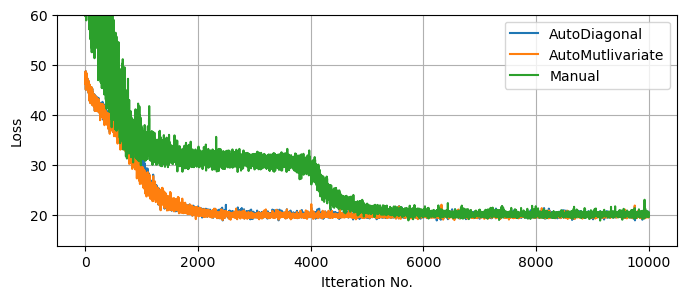

In [5]:
plt.figure(figsize = (8,3))

plt.plot(result_linreg_multi.losses, label = "AutoDiagonal")
plt.plot(result_linreg_diag.losses, label = "AutoMutlivariate")
plt.plot(result_linreg_manual.losses, label = "Manual")

plt.ylabel("Loss")
plt.xlabel("Itteration No.")
plt.ylim(ymax=60)
plt.grid()
plt.legend()
plt.show()

Knowing that our SVI runs are fully converged, we can use them to generate as many samples as we want from the (approximate) posterior. For fairness of comparison, I've kept the number of samples the same as the MCMC run. We can see that, despite the much lower runtime, all three SVI runs do a decent job of matching with the (mostly true) MCMC results, though in places under-representing the non-Gaussian tails. 

Notice that the autoguides go a good job of capturing the asymmetry of $Q$ _despite_ being 'normal' distributions. This is because autoguides fit normal distributions in the _unconstrained_ domain, which are then "squished" back into the $Q\in[0,1]$ domain. This distortion allows normal autoguides to be more flexible than they might first appear, though not infinitely so as we'll see in example 2. By contrast, the manual guide has no distortion at all, the source of its failure to capture the asymmetry in $bg_\sigma$.

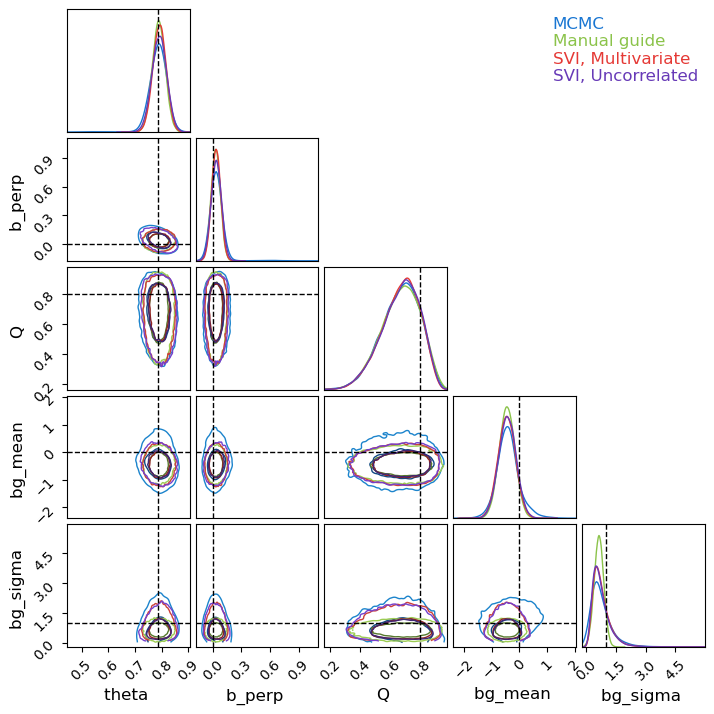

In [6]:
res = sampler.get_samples()

c = ChainConsumer()
c.add_chain(res, name="MCMC")

svi_pred_diag = Predictive(guide_linreg_diag, params = result_linreg_diag.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1))
svi_pred_diag.pop('_auto_latent')

svi_pred_multi = Predictive(guide_linreg_multi, params = result_linreg_multi.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1))
svi_pred_multi.pop('_auto_latent')

svi_pred_manual = Predictive(manual_guide, params = result_linreg_manual.params, num_samples = 20000*2)(rng_key = jax.random.PRNGKey(1), x=x ,y=y, yerr=yerr)

c.add_chain(svi_pred_manual, name="Manual guide")
c.add_chain(svi_pred_multi, name="SVI, Multivariate")
c.add_chain(svi_pred_diag, name="SVI, Uncorrelated")
c.plotter.plot(parameters = ['theta', 'b_perp', 'Q', 'bg_mean', 'bg_sigma'], 
               truth = {'theta':jnp.pi/4, 'b_perp':0, 'Q':0.8, 'bg_mean':0, 'bg_sigma':1})

plt.show()

**Pre-Training SVI**

A major difference between MCMC and SVI is that MCMC contains both an optimization burn-in phase _and_ an exploratory sampling phase, while SVI consists of optimization _only_. If we have some foreknowledge of the distribution, we can initiate our MCMC chains at or near the high likelihood solution to cut down the burn-in time, but the impact of this cleverness is limited by the fact that we will always need a long expensive sampling phase irrespective of how we kick things off. By contrast, SVI is almost all optimization.

For example suppose we're handed a second set of data with similar statistical properties to above, and we want to map the posterior distribution for this new data. Using MCMC, we'd need to _at least_ repeat the $\approx 20,000$ samples, making it about as costly at the first MCMC run. Using SVI instead, we can start at our previous optimal solution and adjust to the new data in a fraction of the time, were we're then free to draw as many samples as we want at near zero cost:

100%|████| 10000/10000 [00:04<00:00, 2258.62it/s, init loss: 18.1025, avg. loss [9501-10000]: 13.7206]


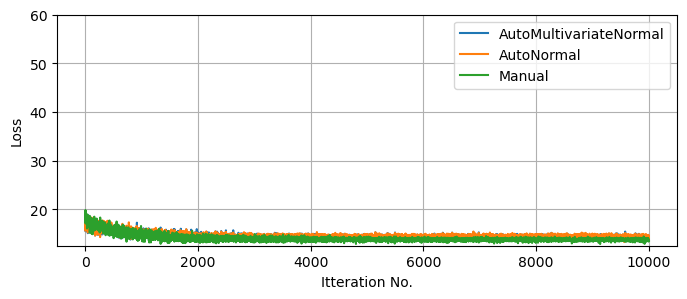

In [7]:
# Generate some new data
xnew, ynew, yerrnew = gen_data(123)

# Run new SVI optimization using old solution as starting point
result_linreg_diag_new = svi_linreg_diag.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params = result_linreg_diag.params)
result_linreg_multi_new = svi_linreg_multi.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params = result_linreg_multi.params)
result_linreg_manual_new = svi_linreg_manual.run(random.PRNGKey(1), svi_samples, xnew, yerrnew, y=ynew, init_params=result_linreg_manual.params)

#-------------------------
# Plot SVI convergence
plt.figure(figsize = (8,3))

plt.plot(result_linreg_diag_new.losses, label = "AutoMultivariateNormal")
plt.plot(result_linreg_multi_new.losses, label = "AutoNormal")
plt.plot(result_linreg_manual_new.losses, label = "Manual")

plt.ylabel("Loss")
plt.xlabel("Itteration No.")
plt.ylim(ymax=60)
plt.grid()
plt.legend()
plt.show()

## Another Practical Example: SVI Vs MCMC In Higher Dimensions For Hierarchial models <a id='Example_2'></a>
In the previous example, we see that SVI competes with or outperforms MCMC in low dimensions ($D<10$), but how does this scale as we climb into the dozens or hundreds of parameters?

As an example, let's consider a _hierarchical_ model of linear regressions, where the measurements of series '$j$' follow a simple linear relationship with linear uncertainty:

$$
    y^j_i \sim N(m^j x_i^j + c^j, E^j_i)
$$

But the gradient '$m^j$' and offset '$c^j$' of each group follow population-wide distributions of unknown mean and variance:

$$
m^j \sim N(\mu_m,\sigma_m), \;\;\; c^j \sim N(\mu_c,\sigma_c) 
$$

If we have $J$ groups, two parameters per group gives us $D=2J+4$ dimensions, allowing the dimensionality of the problem to easily climb into the dozens in realistic cases.

In [8]:
# Data Generation
N_data = 8
xmin, xmax = -10, 10 # Range of X values for data sampling
ebar, escatter = 2.5, 1000 # Average & spread of error bar

lenmin, lenmax = 6, 18

# Gradient & Offset of each line is normally distributed
m_mu, m_sig, c_mu, c_sig = 0.5, 0.2, 10.0, 1.0 
truth = {"m_mu":m_mu, "m_sig":m_sig,"c_mu":c_mu, "c_sig":c_sig}

#-----------------------
# Generate Data
np.random.seed(1)

lens = lenmin + dist.Binomial(lenmax-lenmin,0.5).sample(jax.random.PRNGKey(1), sample_shape=(N_data,)) # Number of samples for each line
DATA = []
Mtrue, Ctrue = [], [] 
for i in range(N_data):
    n = lens[i]

    # Generate X values
    X = np.random.rand(n) * (xmax-xmin) + xmin
    X.sort()

    # Generate slope & Offset for line
    m, c = np.random.randn()*m_sig + m_mu, np.random.randn()*c_sig + c_mu
    Mtrue.append(m), Ctrue.append(c)

    # Generate Errorbars & Y values
    E = (np.random.poisson(lam=escatter, size=len(X)) / escatter + 1)/2 * ebar
    Y = m*X + c + E * np.random.normal(size=len(X)) # Linear rel /w random noise based on 'E'

    # Append to output
    DATA.append({"X":X,
                "Y":Y,
                "E":E})

I        = jnp.concatenate([jnp.array([i]*len(a['X'])) for a,i in zip(DATA,range(len(DATA)))])
X_concat = jnp.concatenate([a['X'] for a in DATA])
Y_concat = jnp.concatenate([a['Y'] for a in DATA])
E_concat = jnp.concatenate([a['E'] for a in DATA])

DATA_concat = ({"I":I,
                "X":X_concat,
                "Y":Y_concat,
                "E":E_concat})

In a practical context, the motivation is that any _one_ source may have insufficient data to constrain $m$ and $c$, but we can leverage their distributions across the entire population to get better constraints. In effect, we're tuning our population-level priors at the same time as we apply them. In this example, we'll uses $J=8$ groups with $I\approx12$ measurements per group. Each group has (with $1\sigma$ uncertainty) a gradient $m=0.5 \pm 0.2$ and offset $c=10 \pm 1$.

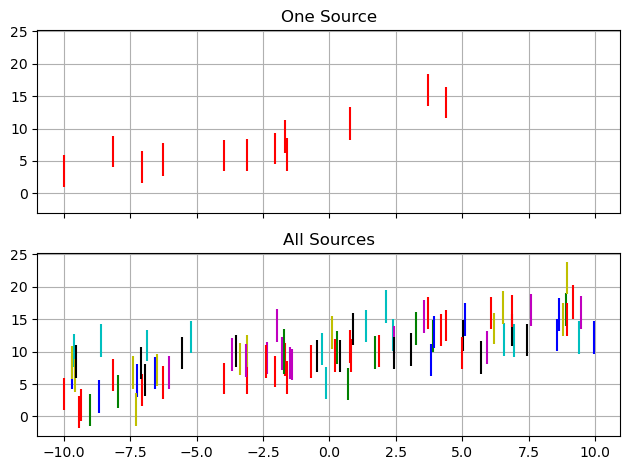

In [9]:
#---------------------
# Plotting

fig, ax = plt.subplots(2,1, sharex=True, sharey=True)

i=0
colors = 'rgbcymk'
colors*=max(1,N_data//len(colors)+1)
colors = list(colors)

ax[0].errorbar(DATA[0]['X'], DATA[0]['Y'], DATA[0]['E'], fmt="none", c = colors[i], label = i)
for data in DATA:
    X,Y,E = data['X'], data['Y'], data['E']
    ax[1].errorbar(X, Y, E, fmt="none", c = colors[i], label = i)
    i+=1

#--------------------------------------------------------

ax[0].grid()
ax[1].grid()
ax[0].set_title("One Source")
ax[1].set_title("All Sources")

#--------------------------------------------------------
plt.tight_layout()
plt.show()

**Define Hierarchical NumPyro Model**  
First, we need to actually define a NumPyro model than can do this hierarchical linear regression. Hierarchical models like this compose easily: the population-level distributions act a bit like priors on each source:

$$
\mathcal{L}(\{ m^j,c^j \},\mu_m, \sigma_m, \mu_c, \sigma_c \vert {\{y\}_i^j}) \propto \prod_j \left(  \prod_i  N(m^j x_i^j + c^j, E^j_i)
\right) \cdot N(m_j-\mu_m,\sigma_m)\cdot N(c_j-\mu_c,\sigma_c) 
$$

Where this likelihood is modulated by extremely vague "hyper-priors" on the population distributions. As $m$ and $c$ can be positive or negative, their mean values can be positive or negative:

$$
\mu_m \sim N(0,15), \;\; \mu_c \sim N(0,25)
$$
But their variability must be restricted to positive values, so I've defined these with wide "half-normal" distributions.
$$
\sigma_m \sim N^+(15), \;\; \sigma_c \sim N^+(25)
$$

Strictly the "correct" way to do this is to use a plate that runs over every group encapsulating each individual linear regression, but I've instead followed the [NumPyro Example](https://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html) for a similar problem. This has the unusual (but computationally efficient) setup of defining _arrays_ of gradients and offsets as a single object:

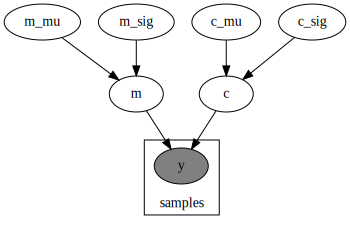

In [10]:
def model_hierarchy(I, X, Y=None, E=None):
    no_sources = len(np.unique(I))

    # Vague Hyperpriors
    m_mu  = numpyro.sample('m_mu',  dist.Normal(0.0, 15.0))
    m_sig = numpyro.sample('m_sig', dist.HalfNormal(10.0))
    c_mu  = numpyro.sample('c_mu',  dist.Normal(0.0, 25.0))
    c_sig = numpyro.sample('c_sig', dist.HalfNormal(15.0))
    

    # Sample grads & offsets for entire population
    m = numpyro.sample('m', dist.Normal(m_mu, m_sig), sample_shape = (no_sources,) )
    c = numpyro.sample('c', dist.Normal(c_mu, c_sig), sample_shape = (no_sources,) )
    pred = m[I]*X+c[I]

    # Use to sample all obervations
    with numpyro.plate('samples', size = len(X) ):
        numpyro.sample('y', dist.Normal(pred, E), obs = Y)

numpyro.render_model( model_hierarchy, model_args = ( I, X_concat, Y_concat, E_concat, ))

Now we can set about running the MCMC and SVI. Later in this example, it's going to become relevant to compare the convergent states of a few different SVI approaches, and I've increased `num_particles` to an absurdly impractical value of $100$, so that we can better compare their "best fit". Because this over-tuning of the samplers throws out the running time, I'm only going to compare the methods in terms of the _number_ of evaluations, a better test of the real-world applications where each sample is costly.

In [11]:
num_warmup = 2000
num_samples = 20000
num_chains = 1

num_particles = 100
svi_samples = 5000
learning_rate = 0.01

#-----------------------------------
# MCMC
MCMC_hierarchy = numpyro.infer.MCMC(numpyro.infer.NUTS(model_hierarchy), 
                                    num_chains = num_chains, num_samples=num_samples, num_warmup = num_warmup, progress_bar = True)

print("Doing MCMC Warmup")
%time MCMC_hierarchy.warmup(jax.random.PRNGKey(1), I, X_concat, Y_concat, E_concat, extra_fields=("potential_energy",), collect_warmup=True)
MCMC_energies_warmup = MCMC_hierarchy.get_extra_fields()["potential_energy"]

print("Doing MCMC Sampling")
%time MCMC_hierarchy.run(jax.random.PRNGKey(1), I, X_concat, Y_concat, E_concat, extra_fields=("potential_energy",))

#-----------------------------------
# SVI
optimizer_hierarchy = numpyro.optim.Adam(step_size=learning_rate)
print("Doing Diagonal SVI")
autoguide_diag = numpyro.infer.autoguide.AutoDiagonalNormal(model_hierarchy)
SVI_diagonal = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_diag,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_diagonal_results = SVI_diagonal.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)

print("Doing Multivariate SVI")
autoguide_multi = numpyro.infer.autoguide.AutoMultivariateNormal(model_hierarchy)
SVI_multivariate = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_multi,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_multivariate_results = SVI_multivariate.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)

Doing MCMC Warmup


warmup: 100%|█████████| 2000/2000 [00:02<00:00, 999.57it/s, 15 steps of size 2.70e-01. acc. prob=0.79]


CPU times: user 2.91 s, sys: 51.5 ms, total: 2.96 s
Wall time: 2.93 s
Doing MCMC Sampling


sample: 100%|██████| 20000/20000 [00:08<00:00, 2414.02it/s, 15 steps of size 2.70e-01. acc. prob=0.88]


CPU times: user 8.4 s, sys: 101 ms, total: 8.5 s
Wall time: 8.46 s
Doing Diagonal SVI


100%|████| 5000/5000 [00:04<00:00, 1109.26it/s, init loss: 1566.4958, avg. loss [4751-5000]: 238.6858]


CPU times: user 5.44 s, sys: 2.7 s, total: 8.14 s
Wall time: 5.07 s
Doing Multivariate SVI


100%|████| 5000/5000 [00:02<00:00, 1802.70it/s, init loss: 1566.4958, avg. loss [4751-5000]: 237.8878]


CPU times: user 3.85 s, sys: 550 ms, total: 4.4 s
Wall time: 3.94 s


Per usual, plot the losses to ensure everything has meaningfully converged. Keep in mind that higher dimensions means more chances for getting pinned in local optima, and so this isn't the _only_ test of convergence, but it still gives us a good view at the optimization speed. As a rough comparison, I've also plotted the 'potential energy' of the MCMC chain, _including_ the burn-in phase. This isn't a perfect one to one comparison, but still helps visualize the comparative timescales of the methods.

The first thing we notice is that, like with a lower dimensional example, SVI converges _extremely_ fast in terms of iterations, and performs decently well in terms of run time even with my absurd particle count. Unsurprisingly, the more expressive `AutoguideMultivariateNormal` settles out to a slightly better fit / lower ELBO, but both methods are well and truly converged at only a few thousand samples, while MCMC still has an order of magnitude more evaluations left to go in its sampling phase.

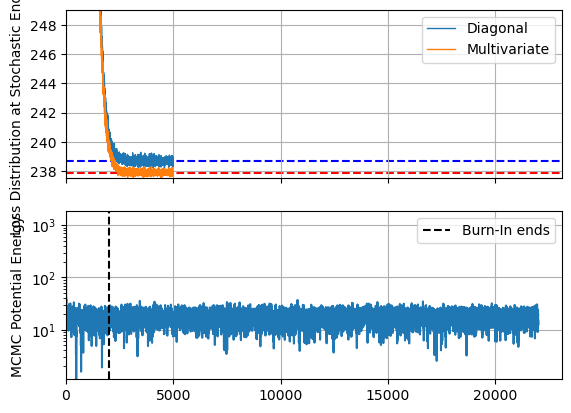

In [12]:
fig, ax = plt.subplots(2,1, sharex=True)

#--------------------------
# SVI plots
ax[0].plot(SVI_diagonal_results.losses, lw=1, label = "Diagonal")
ax[0].plot(SVI_multivariate_results.losses, lw=1, label = "Multivariate")

ax[0].axhline(SVI_diagonal_results.losses[-svi_samples // 10:].mean(), c='b', ls='--', zorder = -2)
ax[0].axhline(SVI_multivariate_results.losses[-svi_samples // 10:].mean(), c='r', ls='--', zorder = -2)

ax[0].set_ylim(ymax=np.min(SVI_multivariate_results.losses)+ np.median(SVI_multivariate_results.losses-np.min(SVI_multivariate_results.losses))*20, ymin=np.min(SVI_multivariate_results.losses))
ax[0].set_ylabel("Loss Distribution at Stochastic End State")

ax[0].grid()
ax[0].legend()

#--------------------------
# MCMC plots
MCMC_energies = np.concatenate([MCMC_energies_warmup, MCMC_hierarchy.get_extra_fields()["potential_energy"]])

ax[1].plot(MCMC_energies - MCMC_energies.min())
ax[1].axvline(num_warmup, c='k', ls='--', label = "Burn-In ends")

ax[1].set_yscale('log')
ax[1].set_ylabel("MCMC Potential Energy")
ax[1].set_xlim(xmin=0)

ax[1].grid()
ax[1].legend()
#--------------------------

plt.show()

Because this model has dozens of samples, I'll restrict my corner plot to only the population-wide hierarchical values. Like before, SVI's Gaussian assumption under-samples the long tails of the distribution, but broadly does a good job of emulating the underlying posterior. There is one marked caveat to this: the contours for the spread in linear offsets, $\sigma_c$. This distribution is _highly_ non-Gaussian, not only in its asymmetry but also in its limiting behaviour at $\lim_{\sigma_c \rightarrow 0}$. The autoguides are using a reparameterization trick to "squash" their Gaussians into the positive domain, but this still means that they need $\lim_{\sigma_c \rightarrow 0} P(\sigma_c)=0$, while the _actual_ distribution (as recovered by MCMC) presses up against that boundary due to the poor constraints on this parameter.

Pulling results for...
	 m_mu
	 m_sig
	 c_mu
	 c_sig


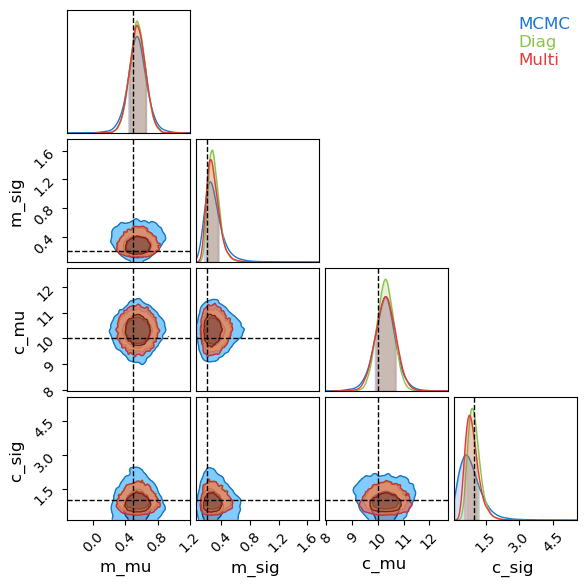

In [13]:
# Acquire Samples
MCMCsamples = MCMC_hierarchy.get_samples()
diagpred = numpyro.infer.Predictive(autoguide_diag, params = SVI_diagonal_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
multipred = numpyro.infer.Predictive(autoguide_multi, params = SVI_multivariate_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

#------------------------------------------
# Extract to Chain Consumer friendly dictionary
mcmc_res = {}
diag_res = {}
multi_res = {}
print("Pulling results for...")
for key in ['m_mu', 'm_sig', 'c_mu', 'c_sig', ]:
    print("\t",key)
    mcmc_res |= {key: MCMCsamples[key]}
    diag_res |= {key: diagpred[key]}
    multi_res|= {key: multipred[key]}

#------------------------------------------
# Plot in ChainConsumer

C_hierarchy = ChainConsumer()

C_hierarchy.add_chain(mcmc_res, name="MCMC")
C_hierarchy.add_chain(diag_res, name="Diag")
C_hierarchy.add_chain(multi_res, name="Multi")

C_hierarchy.plotter.plot(truth=truth)
plt.show()


It's worth noting that this poor recovery on $P(\sigma_c)$ isn't the end of the world, as it's only a measure of the width of a prior. Plotting a summary of the slopes and offsets recovered for each source, SVI is only very slightly over-constrained as compared to MCMC / truth:

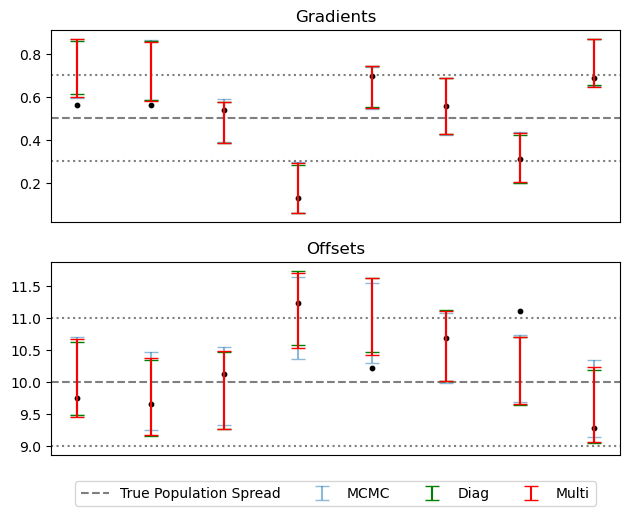

In [14]:
# Acquire SVI samples
A = numpyro.infer.Predictive(autoguide_diag, params = SVI_diagonal_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
B = numpyro.infer.Predictive(autoguide_multi, params = SVI_multivariate_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

# Plotting recovered means / variances
fig, axis = plt.subplots(2,1, sharex = True)
for i, key in enumerate(['m','c']):
    axis[i].errorbar(range(N_data), MCMC_hierarchy.get_samples()[key].mean(axis=0), MCMC_hierarchy.get_samples()[key].std(axis=0), fmt='none', capsize=5, alpha=.5, label = "MCMC")
    
    axis[i].errorbar(range(N_data), A[key].mean(axis=0), A[key].std(axis=0), fmt='none', capsize=5, c='g', label = "Diag")
    axis[i].errorbar(range(N_data), B[key].mean(axis=0), B[key].std(axis=0), fmt='none', capsize=5, c='r', label = "Multi")

    axis[i].axhline(truth[key+"_mu"], c='k', ls="--", alpha=0.5, zorder=-10, label = "True Population Spread")
    axis[i].axhline(truth[key+"_mu"] + truth[key+"_sig"], c='k', ls=":", alpha=0.5, zorder=-10)
    axis[i].axhline(truth[key+"_mu"] - truth[key+"_sig"], c='k', ls=":", alpha=0.5, zorder=-10)

# Plot True values
axis[0].scatter(range(N_data), Mtrue, c='k', s=10, label = "True")
axis[1].scatter(range(N_data), Ctrue, c='k', s=10)

#--------------------------
axis[0].set_xticks([])
axis[0].set_title("Gradients")
axis[1].set_title("Offsets")
#--------------------------
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=4)
plt.show()

### Non-Gaussian Autoguides <a id='Example_2_non_gaussian'></a>

So far, we've found that SVI is a good alternative to MCMC in fitting our hierarchical model, needing only a fraction of the evaluations to emulate the posterior. However, SVI has fallen short in capturing non-Gaussian behaviour of the posterior, specifically in the highly asymmetric and non-Gaussian distribution for $\sigma_c$. Fortunately, all is not lost: a quick look at NumPyro's [SVI autoguide documentaion](https://num.pyro.ai/en/latest/autoguide.html) reveals that, while `AutoDiagonalNormal` and `AutoMutlivariateNormal` are the _first_ tools we might reach for, they are for from the most powerful. Here, we'll take a swing at fitting our hierarchical model using some other _non_-Gaussian methods that NumPyro has to offer, namely:

**DAIS (Differential Annealed Importance Sampling)**  
"_Simulated Annealing_" is a stochastic optimization method in which which a walker navigates around around the likelihood landscape $P(z)$, preferentially moving up-hill, but with some chance to accept a jump to a "worse" position. The walker starts at a "high" temperature where it readily accepts "downhill" steps, but progresses through 'k' stages of "cooling" where becoming more dedicated to optimization instead of exploration. "_Annealed Importance Sampling_" is a variation on simulated annealing that re-weights the samples from these exploratory chains to get a more an MCMC-like output. Instead of changing the particle "temperature", the cooling process can be described as the probability landscape transitioning from a smooth, easy to navigate function (e.g. the prior) into the final objective function, i.e.:

$$
P_k(z) \propto \pi(z)^{\beta_k}\cdot \left(\pi(z) \mathcal{L}(z) \right)^{1-\beta_k}, \;\; \beta_{k+1}>\beta_k, \;\; \beta_k\in[0,1]
$$

While "_Differential Annealed Importance Sampling_" is a variation that uses HMC-like steps in the random movement of the chain so that we can leverage autograd. The trick for using this in conjunction with SVI is that, rather than starting with the _prior_ as our smooth and easy-to-navigate function, we can use instead use a surrogate model from SVI, e.g. a Gaussian. 

$$
P_k(z) \propto q_\phi(z)^{\beta_k}\cdot \left(\pi(z) \mathcal{L}(z) \right)^{1-\beta_k}, \;\; \beta_{k+1}>\beta_k, \;\; \beta_k\in[0,1]
$$

The idea here is that we can get an _approximate_ version of the posterior via standard SVI, and then allow this to diffuse into a non-Gaussian shape though the annealing process. NumPyro parameterizes the cooling scale, ${\beta_k}$, as SVI tuning parameters and attempts to optimize over them along with the initial distribution's $\phi$.

**BNAF (Block Neural Autoregressive Flow)**  & **IAF (Inverse Autoregressive Flows)**  
Normalizing flows are a category of coordinate transformation for probabilistic distributions in which we transform a simple (e.g. Gaussian) distribution through some re-parameterization that matches a more complicated posterior. We can perform this transformation using neural networks, parameterizing an optimizing by the weights and offsets in this network to perform SVI just as we would for a more explicit guide. Different implementations of these normalizing flows rely on different neural architecture, all usually relying on some form that gives an easy to calculate determinant, e.g. by having the neural layers be lower triangular. The specifics of how these work isn't too important here, but we should keep in mind that neural networks like this are _highly parameterized_ and _highly expressive_.

In [15]:
# SVI
print("Doing AutoDAIS SVI")

autoguide_dais = numpyro.infer.autoguide.AutoDAIS(model_hierarchy, K=16, eta_max = 0.12, eta_init = 0.1, gamma_init=0.9)
SVI_dais = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_dais,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_dais_results = SVI_dais.run(jax.random.PRNGKey(1), svi_samples * 10, I, X_concat, Y_concat, E_concat)
print("-"*76)

# BNAF
print("Doing BNAF SVI")
autoguide_bnaf = numpyro.infer.autoguide.AutoBNAFNormal(model_hierarchy)
SVI_bnaf = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_bnaf,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_bnaf_results = SVI_bnaf.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)
print("-"*76)

# IAF
print("Doing IAF SVI")
autoguide_iaf = numpyro.infer.autoguide.AutoIAFNormal(model_hierarchy)
SVI_iaf = numpyro.infer.SVI(model_hierarchy, 
                                 autoguide_iaf,
                                 optim = optimizer_hierarchy, 
                                 loss=numpyro.infer.Trace_ELBO(num_particles=num_particles))
%time SVI_iaf_results = SVI_iaf.run(jax.random.PRNGKey(1), svi_samples, I, X_concat, Y_concat, E_concat,)
print("-"*76)

Doing AutoDAIS SVI


100%|█| 50000/50000 [03:09<00:00, 264.42it/s, init loss: 1030.5693, avg. loss [47501-50000]: 238.3802]


CPU times: user 3min 18s, sys: 1min 24s, total: 4min 42s
Wall time: 3min 14s
----------------------------------------------------------------------------
Doing BNAF SVI


100%|█████| 5000/5000 [00:08<00:00, 564.30it/s, init loss: 1180.0085, avg. loss [4751-5000]: 237.4999]


CPU times: user 16.7 s, sys: 3.12 s, total: 19.9 s
Wall time: 16.5 s
----------------------------------------------------------------------------
Doing IAF SVI


100%|█████| 5000/5000 [00:05<00:00, 965.13it/s, init loss: 1611.8170, avg. loss [4751-5000]: 237.5567]


CPU times: user 6.26 s, sys: 1.46 s, total: 7.72 s
Wall time: 6.22 s
----------------------------------------------------------------------------


After optimizing, we can see that these less traditional SVI guides have managed to capture the non-Gaussianity of $\sigma_c$ quite well, in the case of SVI doing so at _very_ good speed. I've gone with the default parameters and the same optimization time for both the normalizing flow guides, `AutoBNAFNormal` and `AutoIAFNormal`, but _not_ for `AutoDAIS`. In this particular example, DAIS happens to be an extremely inefficient and fragile option, only improving on standard `AutoNormalMultivariate` results with many layers of cooling and a _long_ optimization time. By contrast, the two neural net options converge with good speed and little manual tuning, despite having significantly more parameters (in the low hundreds) to tune.

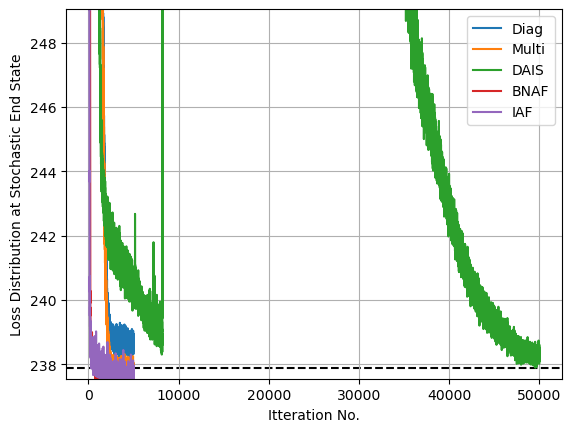

Diag av loss: 	 238.69
Multi av loss: 	 237.89
DAIS av loss: 	 238.36
BNAF av loss: 	 237.52
IAF av loss: 	 237.60


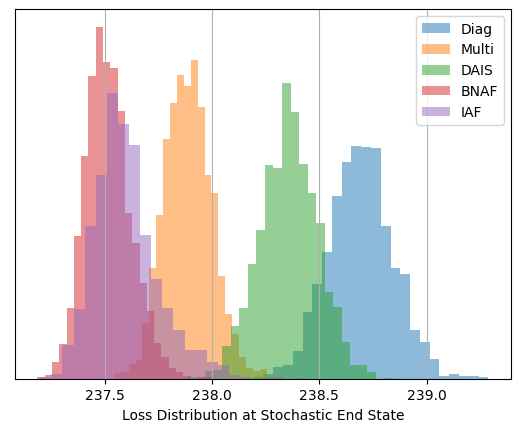

In [16]:
# Collect all results
SVItypes = {}
SVItypes |= {"Diag": [SVI_diagonal_results, 'tab:blue']}
SVItypes |= {"Multi": [SVI_multivariate_results, 'tab:orange']}
SVItypes |= {"DAIS": [SVI_dais_results, 'tab:green']}
SVItypes |= {"BNAF": [SVI_bnaf_results, 'tab:red']}
SVItypes |= {"IAF": [SVI_iaf_results, 'tab:purple']}

#-------------------------
# Loss Convergence Plot
plt.figure()
for name, item in zip(SVItypes.keys(), SVItypes.values()):
    results, color = item[0], item[1]
    plt.plot(results.losses, label = name, c=color)
plt.ylim(0,2000)

plt.legend()
plt.grid()

plt.axhline(SVI_multivariate_results.losses[-num_samples//10:].mean(), c='k', ls='--', zorder=-1)


plt.ylim(ymax=np.min(SVI_multivariate_results.losses)+ np.median(SVI_multivariate_results.losses-np.min(SVI_multivariate_results.losses))*20, ymin=np.min(SVI_multivariate_results.losses))
plt.ylabel("Loss Distribution at Stochastic End State")
plt.xlabel("Itteration No.")

plt.show()

#-------------------------
# Histogram of Final Loss Distributions
plt.figure()
for name, item in zip(SVItypes.keys(), SVItypes.values()):
    results, color = item[0], item[1]
    plt.hist(results.losses[-num_samples//10:], label = name, bins = 24, alpha = 0.5, histtype='stepfilled', density=True)
    print("%s av loss: \t %.2f" %(name,results.losses[-num_samples//10:].mean()))
plt.xlabel("Loss Distribution at Stochastic End State")
plt.yticks([])
plt.legend()
plt.grid()
plt.show()


Now looking at a posterior corner plot for the different methods, we can see how they've managed to adapt much closer to the non-gaussian shapes markedly better than Normal autoguides. Again, DAIS under-performs in this example and hasn't _fully_ converged, but even so it still outperforms the diagonal basis normal guide that it uses as its "base" distribution that it diffuses from.

Pulling results for...
	 m_mu
	 m_sig
	 c_mu
	 c_sig


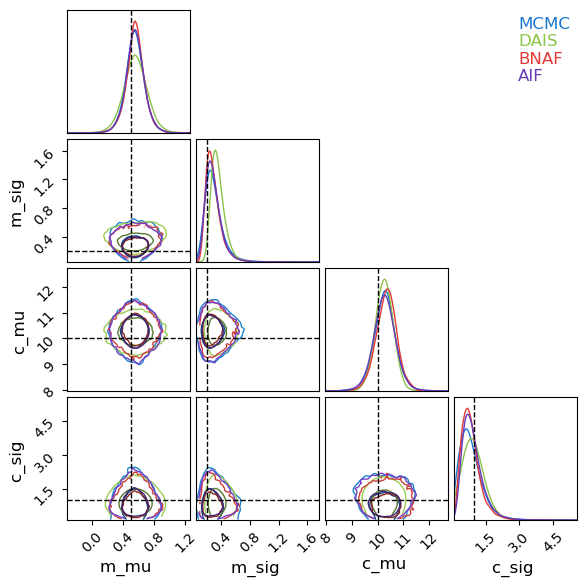

In [17]:
dais_res = {}
bnaf_res = {}
iaf_res = {}

print("Pulling results for...")
daispred = numpyro.infer.Predictive(autoguide_dais, params = SVI_dais_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
bnafpred = numpyro.infer.Predictive(autoguide_bnaf, params = SVI_bnaf_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)
iafpred = numpyro.infer.Predictive(autoguide_iaf, params = SVI_iaf_results.params, num_samples = num_samples*num_chains)(jax.random.PRNGKey(1), I=None, X=None)

for key in ['m_mu', 'm_sig', 'c_mu', 'c_sig', ]:
    print("\t",key)
    dais_res |= {key: daispred[key]}
    bnaf_res |= {key: bnafpred[key]}
    iaf_res|= {key: iafpred[key]}

C_hierarchy = ChainConsumer()

C_hierarchy.add_chain(mcmc_res, name="MCMC")
C_hierarchy.add_chain(dais_res, name="DAIS")
C_hierarchy.add_chain(bnaf_res, name="BNAF")
C_hierarchy.add_chain(iaf_res, name="AIF")

C_hierarchy.plotter.plot(truth=truth,)

plt.show()
